<a href="https://colab.research.google.com/github/Akankshaaaa-01/Assignment-Submission-Portal/blob/main/Cardiovascular_disease_prediction_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
!pip install pyspark -q

from pyspark.sql import SparkSession
from pyspark.sql.functions import col, when
from pyspark.ml.feature import VectorAssembler, StandardScaler, StringIndexer
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator
import pandas as pd


In [52]:
spark = SparkSession.builder.appName("CardioDiseasePrediction").getOrCreate()

data = pd.read_csv("Cardiovascular Diseases Risk Prediction Dataset.csv")
spark_df = spark.createDataFrame(data)
print(f"Loaded {spark_df.count():,} rows.")


Loaded 99,999 rows.


In [55]:
for col_name in ["Heart_Disease", "Exercise", "Skin_Cancer", "Other_Cancer",
                 "Depression", "Diabetes", "Arthritis"]:
    spark_df = spark_df.withColumn(col_name, when(col(col_name) == "Yes", 1).otherwise(0))


In [56]:
cat_cols = ["General_Health", "Checkup", "Sex", "Age_Category", "Smoking_History"]
indexers = [StringIndexer(inputCol=c, outputCol=f"{c}_Index").fit(spark_df) for c in cat_cols]
for i in indexers:
    spark_df = i.transform(spark_df)


In [57]:
feature_cols = [
    "General_Health_Index", "Checkup_Index", "Exercise",
    "Skin_Cancer", "Other_Cancer", "Depression", "Diabetes", "Arthritis",
    "Sex_Index", "Age_Category_Index", "Height_(cm)", "Weight_(kg)", "BMI",
    "Smoking_History_Index", "Alcohol_Consumption", "Fruit_Consumption",
    "Green_Vegetables_Consumption", "FriedPotato_Consumption"
]

assembler = VectorAssembler(inputCols=feature_cols, outputCol="features_raw")
assembled = assembler.transform(spark_df)

scaler = StandardScaler(inputCol="features_raw", outputCol="features")
scaler_model = scaler.fit(assembled)
scaled_data = scaler_model.transform(assembled)

train_data, test_data = scaled_data.randomSplit([0.7, 0.3], seed=42)


In [125]:
train_weighted = train_data.withColumn("weight", when(col("Heart_Disease") == 1, 5.75).otherwise(0.5))
lr_model = LogisticRegression(featuresCol="features", labelCol="Heart_Disease", weightCol="weight").fit(train_weighted)
rf_model = RandomForestClassifier(featuresCol="features", labelCol="Heart_Disease").fit(train_data)

In [126]:
evaluator = BinaryClassificationEvaluator(labelCol="Heart_Disease")
lr_auc = evaluator.evaluate(lr_model.transform(test_data))
rf_auc = evaluator.evaluate(rf_model.transform(test_data))

print(f"LR AUC: {lr_auc:.3f} | RF AUC: {rf_auc:.3f}")
chosen_model = lr_model if lr_auc > rf_auc else rf_model
print(f"Best: {'RF' if rf_auc > lr_auc else 'LR'} (AUC: {max(lr_auc, rf_auc):.3f})")

LR AUC: 0.790 | RF AUC: 0.764
✅ Best: LR (AUC: 0.790)


In [137]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
predictions = lr_model.transform(test_data)
total = predictions.count()
correct = predictions.filter(predictions.prediction == predictions.Heart_Disease).count()

accuracy = correct / total
print(f"Accuracy: {accuracy*100:.2f}%")



Accuracy: 72.22%


In [127]:
#HIGH RISK: Elderly obese smoker with multiple conditions
sample_user_1 = [("Poor", "5 or more years ago", "No", "No", "No", "No",
                  "Yes", "Yes", "Yes", "Male", "80+", 175, 110, 35.9, "Yes", 12, 2, 2, 20)]

# LOW RISK: Young healthy female with active lifestyle
sample_user_2 = [("Excellent", "Within the past year", "Yes", "No", "No", "No", "No", "No",
                  "No", "Female", "18-24", 165, 58, 21.3, "No", 0, 30, 28, 2)]

user_columns = ["General_Health", "Checkup", "Exercise", "Heart_Disease", "Skin_Cancer",
                "Other_Cancer", "Depression", "Diabetes", "Arthritis", "Sex", "Age_Category",
                "Height_(cm)", "Weight_(kg)", "BMI", "Smoking_History", "Alcohol_Consumption",
                "Fruit_Consumption", "Green_Vegetables_Consumption", "FriedPotato_Consumption"]



In [128]:
for idx, sample_user in enumerate([sample_user_1, sample_user_2], 1):
    user_df = spark.createDataFrame(sample_user, user_columns)

    # Convert Yes/No to 1/0
    for c in ["Exercise", "Heart_Disease", "Skin_Cancer", "Other_Cancer", "Depression", "Diabetes", "Arthritis"]:
        user_df = user_df.withColumn(c, when(col(c) == "Yes", 1).otherwise(0))

    for indexer in indexers:
        user_df = indexer.transform(user_df)

    features_df = scaler_model.transform(assembler.transform(user_df))


    prob = chosen_model.transform(features_df).select("probability").collect()[0][0][1]
    if prob >= 0.7:
        risk = "VERY HIGH RISK"
    elif prob >= 0.4:
        risk = "HIGH RISK"
    elif prob >= 0.2:
        risk = "MODERATE RISK"
    else:
        risk = "LOW RISK"

    print(f"User {idx}: {prob:.1%} → {risk}")


User 1: 80.7% → VERY HIGH RISK
User 2: 18.2% → LOW RISK


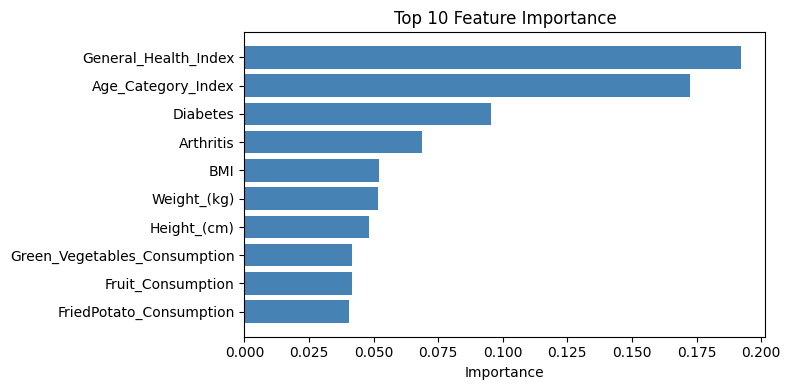

In [87]:
import matplotlib.pyplot as plt
import pandas as pd

feat_imp = rf_model.featureImportances.toArray()
feat_df = pd.DataFrame({'Feature': feature_cols, 'Importance': feat_imp}).sort_values('Importance', ascending=False).head(10)

plt.figure(figsize=(8,4))
plt.barh(feat_df['Feature'], feat_df['Importance'], color='steelblue')
plt.gca().invert_yaxis()
plt.xlabel('Importance')
plt.title('Top 10 Feature Importance')
plt.tight_layout()
plt.show()


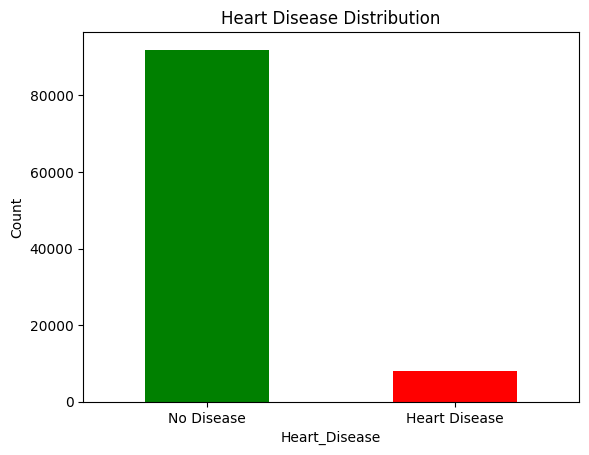

In [88]:
pdf = spark_df.select("Heart_Disease").toPandas()
pdf['Heart_Disease'].value_counts().plot(kind='bar', color=['green','red'])
plt.xticks([0,1], ['No Disease','Heart Disease'], rotation=0)
plt.ylabel('Count')
plt.title('Heart Disease Distribution')
plt.show()




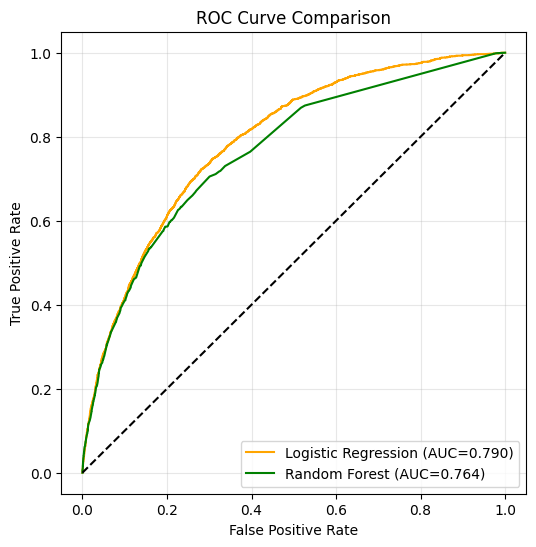

In [130]:
from sklearn.metrics import roc_curve, auc

def get_roc(model, test_data):
    pred = model.transform(test_data)
    y_true = pred.select("Heart_Disease").rdd.map(lambda x: x[0]).collect()
    y_scores = pred.select("probability").rdd.map(lambda x: float(x[0][1])).collect()
    fpr, tpr, _ = roc_curve(y_true, y_scores)
    return fpr, tpr, auc(fpr, tpr)

fpr_lr, tpr_lr, auc_lr = get_roc(lr_model, test_data)
fpr_rf, tpr_rf, auc_rf = get_roc(rf_model, test_data)

plt.figure(figsize=(6,6))
plt.plot(fpr_lr, tpr_lr, label=f'Logistic Regression (AUC={auc_lr:.3f})', color='orange')
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC={auc_rf:.3f})', color='green')
plt.plot([0,1],[0,1],'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend()
plt.grid(alpha=0.3)
plt.show()


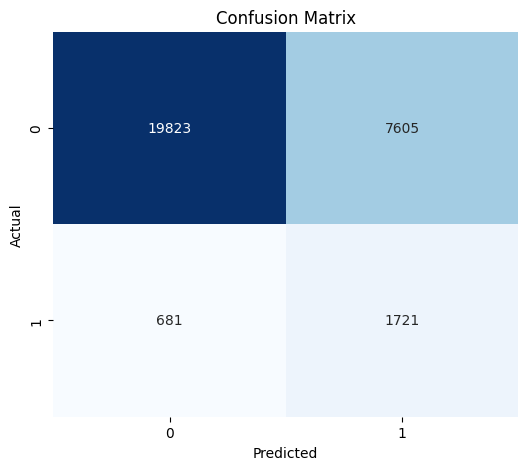

In [132]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

predictions = chosen_model.transform(test_data)

y_true = predictions.select("Heart_Disease").rdd.map(lambda x: x[0]).collect()
y_pred = predictions.select("prediction").rdd.map(lambda x: x[0]).collect()

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

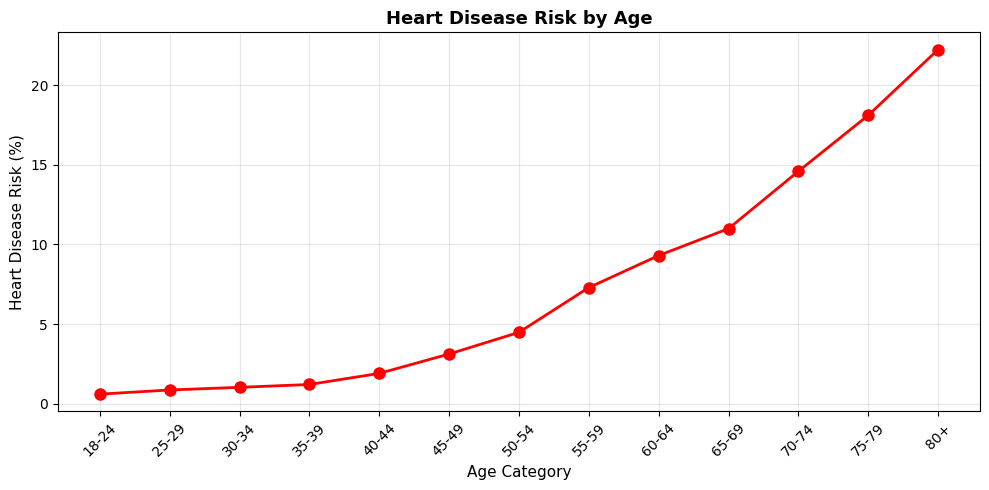

In [91]:
pdf = spark_df.select("Age_Category", "Heart_Disease").toPandas()
age_order = ["18-24", "25-29", "30-34", "35-39", "40-44", "45-49", "50-54", "55-59", "60-64", "65-69", "70-74", "75-79", "80+"]

age_risk = pdf.groupby('Age_Category')['Heart_Disease'].mean().reindex(age_order) * 100

plt.figure(figsize=(10, 5))
plt.plot(age_risk.index, age_risk.values, marker='o', color='red', linewidth=2, markersize=8)
plt.xlabel('Age Category', fontsize=11)
plt.ylabel('Heart Disease Risk (%)', fontsize=11)
plt.title('Heart Disease Risk by Age', fontsize=13, fontweight='bold')
plt.xticks(rotation=45)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()